In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# open_pickle

def open_pickle(path):
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

### Load data

In [4]:
#Load dataset of [relevant,-relevant]

X_train_sentence = open_pickle('../data/imdb-sentence/imdb_sentence_xtrain.pickle')
X_test_sentence = open_pickle('../data/imdb-sentence/imdb_sentence_xtest.pickle')
y_train_sentence = open_pickle('../data/imdb-sentence/imdb_sentence_ytrain.pickle')
y_test_sentence = open_pickle('../data/imdb-sentence/imdb_sentence_ytest.pickle')

#Load dataset of [+/-]

X_train_original = open_pickle('../data/imdb/imdb_original_preprocessed_xtrain.pickle')
X_test_original = open_pickle('../data/imdb/imdb_original_preprocessed_xtest.pickle')
y_train_original = open_pickle('../data/imdb/imdb_original_preprocessed_ytrain.pickle')
y_test_original = open_pickle('../data/imdb/imdb_original_preprocessed_ytest.pickle')

In [28]:
# Baseline

token = r"(?u)\b[\w\'/]+\b"
cv = CountVectorizer(lowercase=True, min_df=5, binary=True, token_pattern=token)

X_tr_baseline = cv.fit_transform(X_train_original)
X_te_baseline = cv.transform(X_test_original)

print(len(cv.get_feature_names()))

26266


In [33]:
print(X_tr_baseline.shape)
print(y_train_original.shape)

(25000, 26266)
(25000,)


In [38]:
clf = LogisticRegression(random_state=42, C=0.01)

clf.fit(X_tr_baseline, y_train_original)


print(clf.score(X_tr_baseline, y_train_original))
print(clf.score(X_te_baseline, y_test_original))

0.90968
0.8794


### Approach

In [35]:
# Count Vectorizer on rel,unrel dataset
# Question : Why rel/unrel? Because it trained as the first step? 
# Any advantages on more vocabulary?



token = r"(?u)\b[\w\'/]+\b"
tf_vectorizer = CountVectorizer(lowercase=True, max_df=1.0, min_df=1, binary=True, token_pattern=token)
tf_vectorizer.set_params(ngram_range=(1,1))

X_train_sentence_bow = tf_vectorizer.fit_transform(X_train_sentence)
X_test_sentence_bow = tf_vectorizer.transform(X_test_sentence)

X_train_original_bow = tf_vectorizer.transform(X_train_original)
X_test_original_bow = tf_vectorizer.transform(X_test_original)


words = tf_vectorizer.get_feature_names()
print(len(words))

4532


In [37]:
# Again baseline

clf = LogisticRegression(random_state=42, C=0.01)

clf.fit(X_train_original_bow, y_train_original)

print(clf.score(X_train_original_bow, y_train_original))
print(clf.score(X_test_original_bow, y_test_original))

0.88508
0.86832


In [6]:
print(y_train_sentence.shape)
print(y_test_sentence.shape)
print(y_train_original.shape)
print(y_test_original.shape)

(1333,)
(667,)
(25000,)
(25000,)


In [7]:
def lr_classifier_report(X_tr, y_tr, X_te, y_te, random_state=42, C=1.0):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt

    clf = LogisticRegression(random_state=random_state, C=C)
    clf.fit(X_tr, y_tr)

    y_predict = clf.predict(X_te)

    print('--------------')
    print('C=%.2f' %(C))
    print('--------------')
    print('Accuracy')
    print('Train:\t%.5f ' %(clf.score(X_tr, y_tr)))
    print('Test:\t%.5f ' %(clf.score(X_te, y_te)))
    
    print(classification_report(y_te,y_predict))
    #############################################################################
    y_score = clf.decision_function(X_te)
    
    precision, recall, _ = precision_recall_curve(y_te, y_score)
    average_precision = average_precision_score(y_te, y_score)
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
    plt.show()
    plt.clf()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_te, y_score)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return clf

### Train to [rel,unrel] classifier

In [26]:
# Okay... Using the function makes me more overwhelmed. Let's do it manually.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

random_state = 42
C = 0.01

clf = LogisticRegression(random_state=random_state, C=C)
clf.fit(X_train_sentence_bow, y_train_sentence)

y_predict = clf.predict(X_test_sentence_bow)

print('--------------')
print('C=%.2f' %(C))
print('--------------')
print('Accuracy')
print('Train:\t%.5f ' %(clf.score(X_train_sentence_bow, y_train_sentence)))
print('Test:\t%.5f ' %(clf.score(X_test_sentence_bow, y_test_sentence)))
    
print(classification_report(y_test_sentence,y_predict))

--------------
C=0.01
--------------
Accuracy
Train:	0.76819 
Test:	0.69415 
             precision    recall  f1-score   support

        0.0       0.77      0.63      0.69       363
        1.0       0.64      0.77      0.70       304

avg / total       0.71      0.69      0.69       667



--------------
C=0.10
--------------
Accuracy
Train:	0.88897 
Test:	0.75862 
             precision    recall  f1-score   support

        0.0       0.80      0.74      0.77       363
        1.0       0.71      0.79      0.75       304

avg / total       0.76      0.76      0.76       667



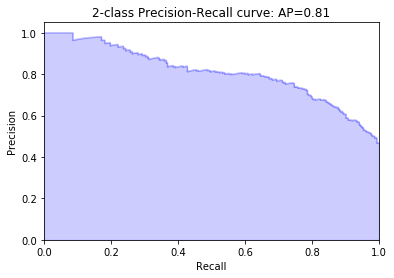

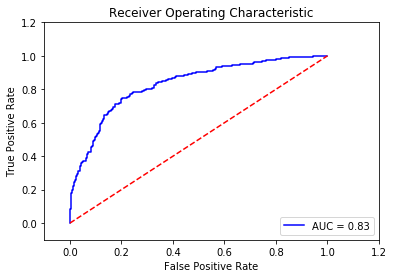

In [8]:
clf_rel = lr_classifier_report(X_train_sentence_bow, y_train_sentence, X_test_sentence_bow, y_test_sentence, C=0.1)

### Train [+,-] classifier

--------------
C=0.10
--------------
Accuracy
Train:	0.91368 
Test:	0.87120 
             precision    recall  f1-score   support

          0       0.87      0.87      0.87     12500
          1       0.87      0.87      0.87     12500

avg / total       0.87      0.87      0.87     25000



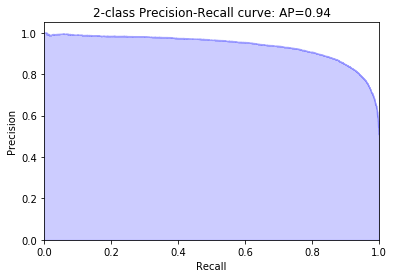

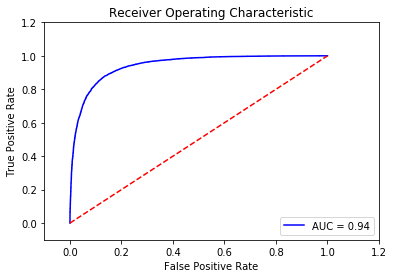

In [9]:
clf_np = lr_classifier_report(X_train_original_bow, y_train_original, X_test_original_bow, y_test_original, C=0.1)

### Test

In [10]:
# Get the test data

def get_sentences(corpus):
    from textblob import TextBlob
    text = TextBlob(corpus)
    i = 0
    sent = []
    for sentence in text.raw_sentences:
        sent.append(sentence)
    return sent

def nested_classifier(clf_rel, clf_np, cv, X, threshold=None, most_confidence_related=True, most_confidence_label=False):
    y_pred = []
    
    for corpus in X:
    
        sentences = get_sentences(corpus)
        sentence_set = cv.transform(sentences)
        
        if threshold==None:
            y_ind_proba = clf_rel.predict_proba(sentence_set)
            y_ind = clf_rel.predict(sentence_set)
        else:
            y_ind_proba = clf_rel.predict_proba(sentence_set)
            y_ind = y_ind_proba[:,1]>threshold
        
        
        
        # make case when there is no related sentence
        if np.sum(y_ind) == 0:
            y_pred.append(-1)
            continue
        elif np.sum(y_ind) == 1:
            y = clf_np.predict(sentence_set[np.array(np.where(y_ind == 1)).T.flatten(), :])
            y_pred.append(y[0])
        else:
            '''
            Only picks the highest confidence of related sentence. 
            '''
            
#            indices = np.array(np.where(y_ind == 1)).flatten()
            indices = np.array(np.argmax(y_ind_proba[:,1])).flatten()
            y = clf_np.predict(sentence_set[indices, :])
            y_pred.append(y)
        #    y_pred.append(-2)
    
    return np.array(y_pred)

In [11]:
# Get the test data

def get_sentences(corpus):
    from textblob import TextBlob
    text = TextBlob(corpus)
    sent = []
    for sentence in text.raw_sentences:
        sent.append(sentence)
    return sent

# most_confidence related when you pick the highest confidence sentence in the first step. Thus, no need to pick the highest confidence
# in the second step. 
def nested_classifier(clf_rel, clf_np, cv, X, threshold=None, highest_confidence_related=True):
    y_pred = []
    
    for corpus in X:
        '''
        Breakdown the corpus into sentence and transform into bag-of-words
        '''
        sentences = get_sentences(corpus)
        sentence_set = cv.transform(sentences)
        
        '''
        Related classifier given threshold. 
        threshold, if None, it only predict the label. If float number given, assign the threshold to the sentence with
        probability over threshold
        '''
        if threshold==None:
            y_ind_proba = clf_rel.predict_proba(sentence_set)
            y_ind = clf_rel.predict(sentence_set)
        else:
            y_ind_proba = clf_rel.predict_proba(sentence_set)
            y_ind = y_ind_proba[:,1]>threshold
        
        '''
        +/- classifier given the sentences from the previous classifier
        if 0, assign the label as -1 (which means it does not have any related sentence)
        else, classify the sentence into +/- label according to the given sentence. 
        '''
        if np.sum(y_ind) == 0:
            y_pred.append(-1)
            continue
        else:
            
            
            if highest_confidence_related:
                indices = np.array(np.argmax(y_ind_proba[:,1])).flatten()
                y = clf_np.predict(sentence_set[indices, :])
                y_pred.append(y)
            else:
                indices = np.array(np.where(y_ind[:,1] == 1)).flatten()
                y_np_proba = clf_np.predict_proba(sentence_set[indices, :])
                y_neg_proba = np.max(y_np_proba[:,0])
                y_pos_proba = np.max(y_np_proba[:,1])
                if y_pos_proba > y_neg_proba:
                    y_pred.append(1)
                else:
                    y_pred.append(0)
                
                
    return np.array(y_pred)

In [12]:
# Build an accuracy function excluding those -1



In [13]:
y = nested_classifier(clf_rel, clf_np, tf_vectorizer, X_test_original, threshold=None)
print(np.sum(y == y_test_original)/len(y_test_original))

y_indices = np.array(np.where((y == 1) | (y == 0))).flatten()
y_pred = y[y_indices]
y_ori = y_test_original[y_indices]

print(np.sum(y_pred == y_ori)/len(y_indices))

0.73088
0.7462528078415356


In [14]:
print(np.sum(y == y_test_original)/len(y_test_original))
print(np.sum(y_pred == y_ori)/len(y_indices))

0.73088
0.7462528078415356


In [15]:
y = nested_classifier(clf_rel, clf_np, tf_vectorizer, X_test_original, threshold=0.75)
print(np.sum(y == y_test_original)/len(y_test_original))

y_indices = np.array(np.where((y == 1) | (y == 0))).flatten()
y_pred = y[y_indices]
y_ori = y_test_original[y_indices]

print(np.sum(y_pred == y_ori)/len(y_indices))

0.56728
0.7612044442058934


In [16]:
y = nested_classifier(clf_rel, clf_np, tf_vectorizer, X_test_original, threshold=0.9)
print(np.sum(y == y_test_original)/len(y_test_original))

y_indices = np.array(np.where((y == 1) | (y == 0))).flatten()
y_pred = y[y_indices]
y_ori = y_test_original[y_indices]

print(np.sum(y_pred == y_ori)/len(y_indices))

0.17436
0.7977672035139092


In [17]:
y = nested_classifier(clf_rel, clf_np, tf_vectorizer, X_test_original, threshold=0.99)
print(np.sum(y == y_test_original)/len(y_test_original))

y_indices = np.array(np.where((y == 1) | (y == 0))).flatten()
y_pred = y[y_indices]
y_ori = y_test_original[y_indices]

print(np.sum(y_pred == y_ori)/len(y_indices))

0.00132
0.9428571428571428
